<a href="https://colab.research.google.com/github/RysanDeluna/Quantum/blob/main/Grad_Research/QuantumCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Get packages
%%capture
!pip install qiskit qiskit_aer qiskit_ibm_runtime numpy pandas  matplotlib pylatexenc

In [ ]:
#@title Setup IBM account details
from google.colab import userdata
from qiskit_ibm_runtime import QiskitRuntimeService

my_token = userdata.get('QISKIT_TOKEN')
service = QiskitRuntimeService(channel="ibm_quantum", token=my_token)

Importing the functions we're going to need in order to construct the circuit.

In [ ]:
%%capture
!pip install "ipykernel<6"

In [ ]:
from qiskit import QuantumCircuit, QuantumRegister, AncillaRegister, ClassicalRegister
from qiskit.circuit.library import HGate, CXGate, TGate, ZGate

The function bellow is responsible for linking the control and state qubits for each cell. It receives a `QuantumCircuit` and both the control and state registers.

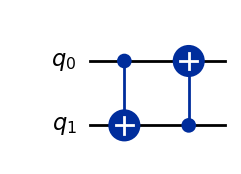

In [ ]:
def cell_link():
  cell_link = QuantumCircuit(2)
  cell_link.append(CXGate(),[0,1])
  cell_link.append(CXGate(),[1,0])
  return cell_link
cell_link().draw('mpl')

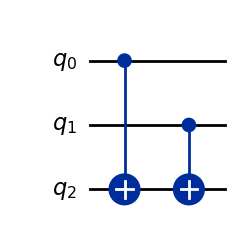

In [ ]:
def xor():
  qc = QuantumCircuit(3, name='xor')
  qc.append(CXGate(), [0,2])
  qc.append(CXGate(), [1,2])
  return qc
xor().draw('mpl')

The function bellow represents the first part and it inserts the transition rule for the CA into the circuit.
It accepts a circuit, the registers and also the function that will define the rule, whilst having it preset to the 90 rule.  

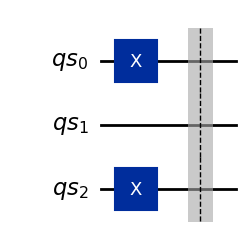

In [ ]:
import numpy as np
from qiskit import QuantumCircuit

def prepare_initial_state(qc, data=None):
  if not data:
    data = np.zeros(qc.qregs[0].size)
    data[int(len(data)/2)] = 1
  for i in range(len(data)):
    if data[i] == 0:
      qc.x(i)
  qc.barrier()
  return qc

reg_stat = QuantumRegister(size=3, name='qs')
reg_ctrl = QuantumRegister(size=3, name='qc')
qc  = QuantumCircuit(reg_stat)
prepare_initial_state(qc).draw('mpl')

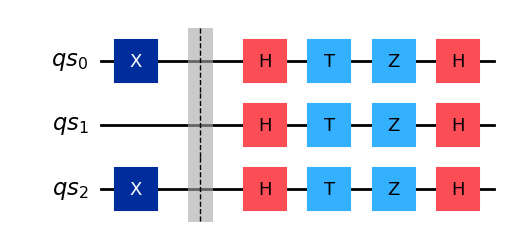

In [ ]:
def sup():
  qc = QuantumCircuit(1, name='HTZH')
  qc.append(HGate(), [0])
  qc.append(TGate(), [0])
  qc.append(ZGate(), [0])
  qc.append(HGate(), [0])
  return qc

def superposition(qc: QuantumCircuit, reg_stat: QuantumRegister):
  for i in range(len(reg_stat)):
    qc.compose(sup(), reg_stat[i], inplace=True)
  return qc

superposition(qc, reg_stat).draw('mpl')

In [ ]:
def part1(qc: QuantumCircuit,
          reg_stat=QuantumRegister(size=3, name="qs"),
          reg_ctrl=QuantumRegister(size=3, name="qc"),
          rule=xor()):
  qc.reset(reg_ctrl)
  qc.compose(rule, [reg_stat[len(reg_stat)-1], reg_stat[1], reg_ctrl[0]], inplace=True)  # Para a célula mais à esquerda
  for i in range(1,len(reg_stat)-1):
    qc.compose(rule, [reg_stat[i-1], reg_stat[i+1], reg_ctrl[i]], inplace=True)
  qc.compose(rule, [reg_stat[len(reg_stat)-2], reg_stat[0], reg_ctrl[len(reg_stat)-1]], inplace=True)  # Para a célula mais à direita
  qc.barrier()
  return qc

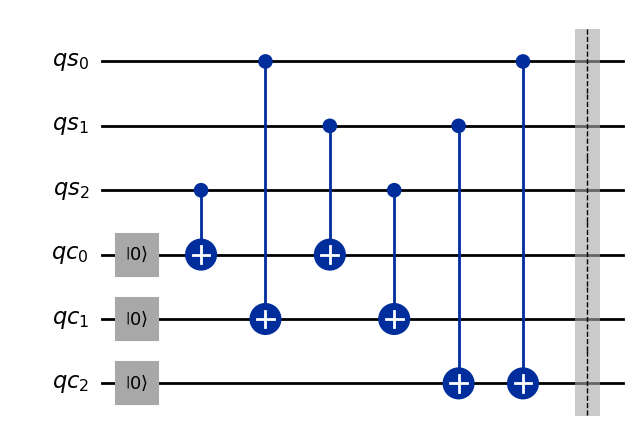

In [ ]:
qc = QuantumCircuit(reg_stat, reg_ctrl)
part1(qc, reg_stat, reg_ctrl).draw('mpl')

In [ ]:
def part2(qc: QuantumCircuit,
          reg_stat=QuantumRegister(size=3, name="qs"),
          reg_ctrl=QuantumRegister(size=3, name="qc"),
          cell_link=cell_link()):
  # For each cell, link its state and control qubits
  for i in range(len(reg_stat)):
    qc.compose(cell_link, [reg_stat[i],reg_ctrl[i]], inplace=True)
  qc.barrier()
  return qc

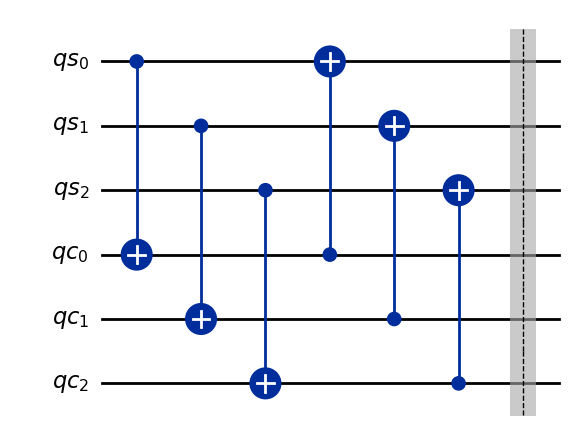

In [ ]:
qc = QuantumCircuit(reg_stat, reg_ctrl)
part2(qc, reg_stat, reg_ctrl).draw('mpl')

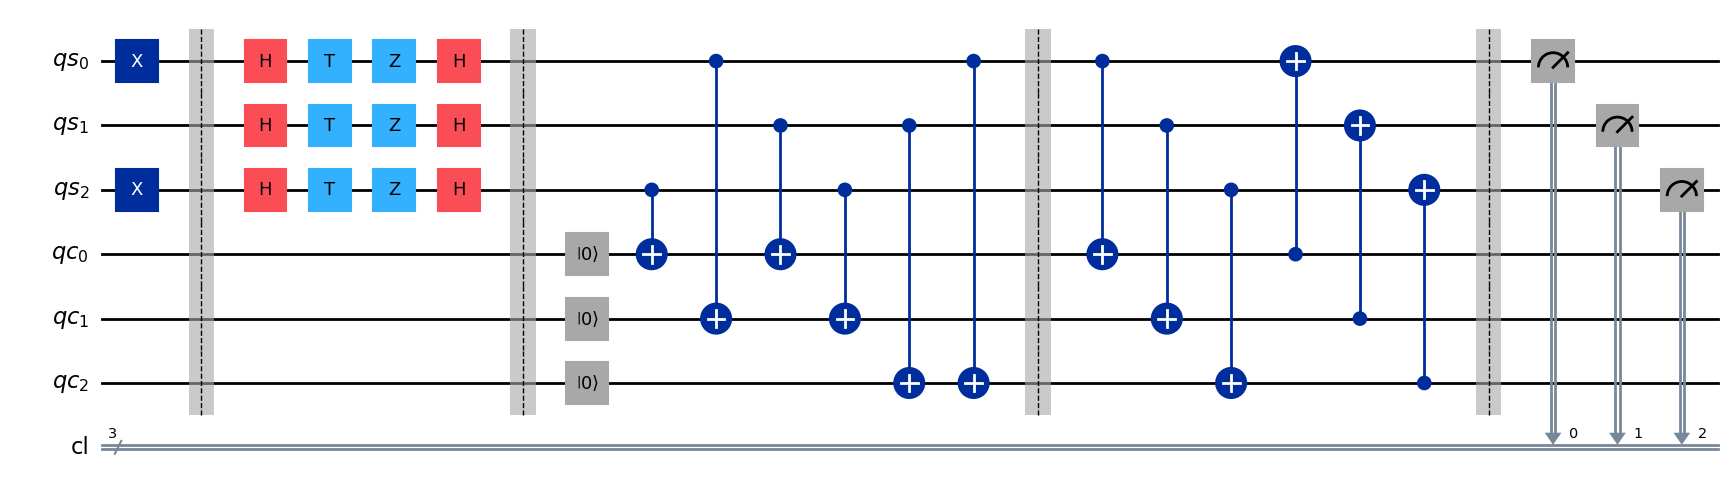

In [ ]:
qc = QuantumCircuit(reg_stat, reg_ctrl, ClassicalRegister(size=3, name="cl"))
qc = prepare_initial_state(qc)
qc = superposition(qc, reg_stat)
qc.barrier()
qc = part1(qc, reg_stat, reg_ctrl)
qc = part2(qc, reg_stat, reg_ctrl)
qc.measure(reg_stat, ClassicalRegister(size=3, name="cl"))
qc.draw('mpl')

The code bellow will use the functions defined above to make an iteration of the cellular automata.

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
# Variables
size = 7
N_ITERACOES = 22
data = np.zeros(size, dtype=int)
data[int(size/2)] = 1

In [ ]:
# Creating the registers
reg_stat = QuantumRegister(size=size, name="qs")
reg_ctrl = QuantumRegister(size=size, name="qc")
reg_clas = ClassicalRegister(size=size, name="cl")

In [ ]:
from qiskit.quantum_info import Statevector

def ca_oracle(iterations, data=None):
  # Constructing the circuit
  qc_ca = QuantumCircuit(reg_stat, reg_ctrl, reg_clas, name="qc_ca")

  # Put all the state variables in superposition while rotating the qubit to deal with the configuration of the system
  qc_ca = prepare_initial_state(qc_ca, data)
  qc_ca = superposition(qc_ca, reg_stat)

  # Implement the rule within the system
  for i in range(iterations):
    qc_ca = part1(qc_ca, reg_stat, reg_ctrl)
    qc_ca = part2(qc_ca, reg_stat, reg_ctrl)

  qc_ca.measure(reg_stat, reg_clas)
  return qc_ca

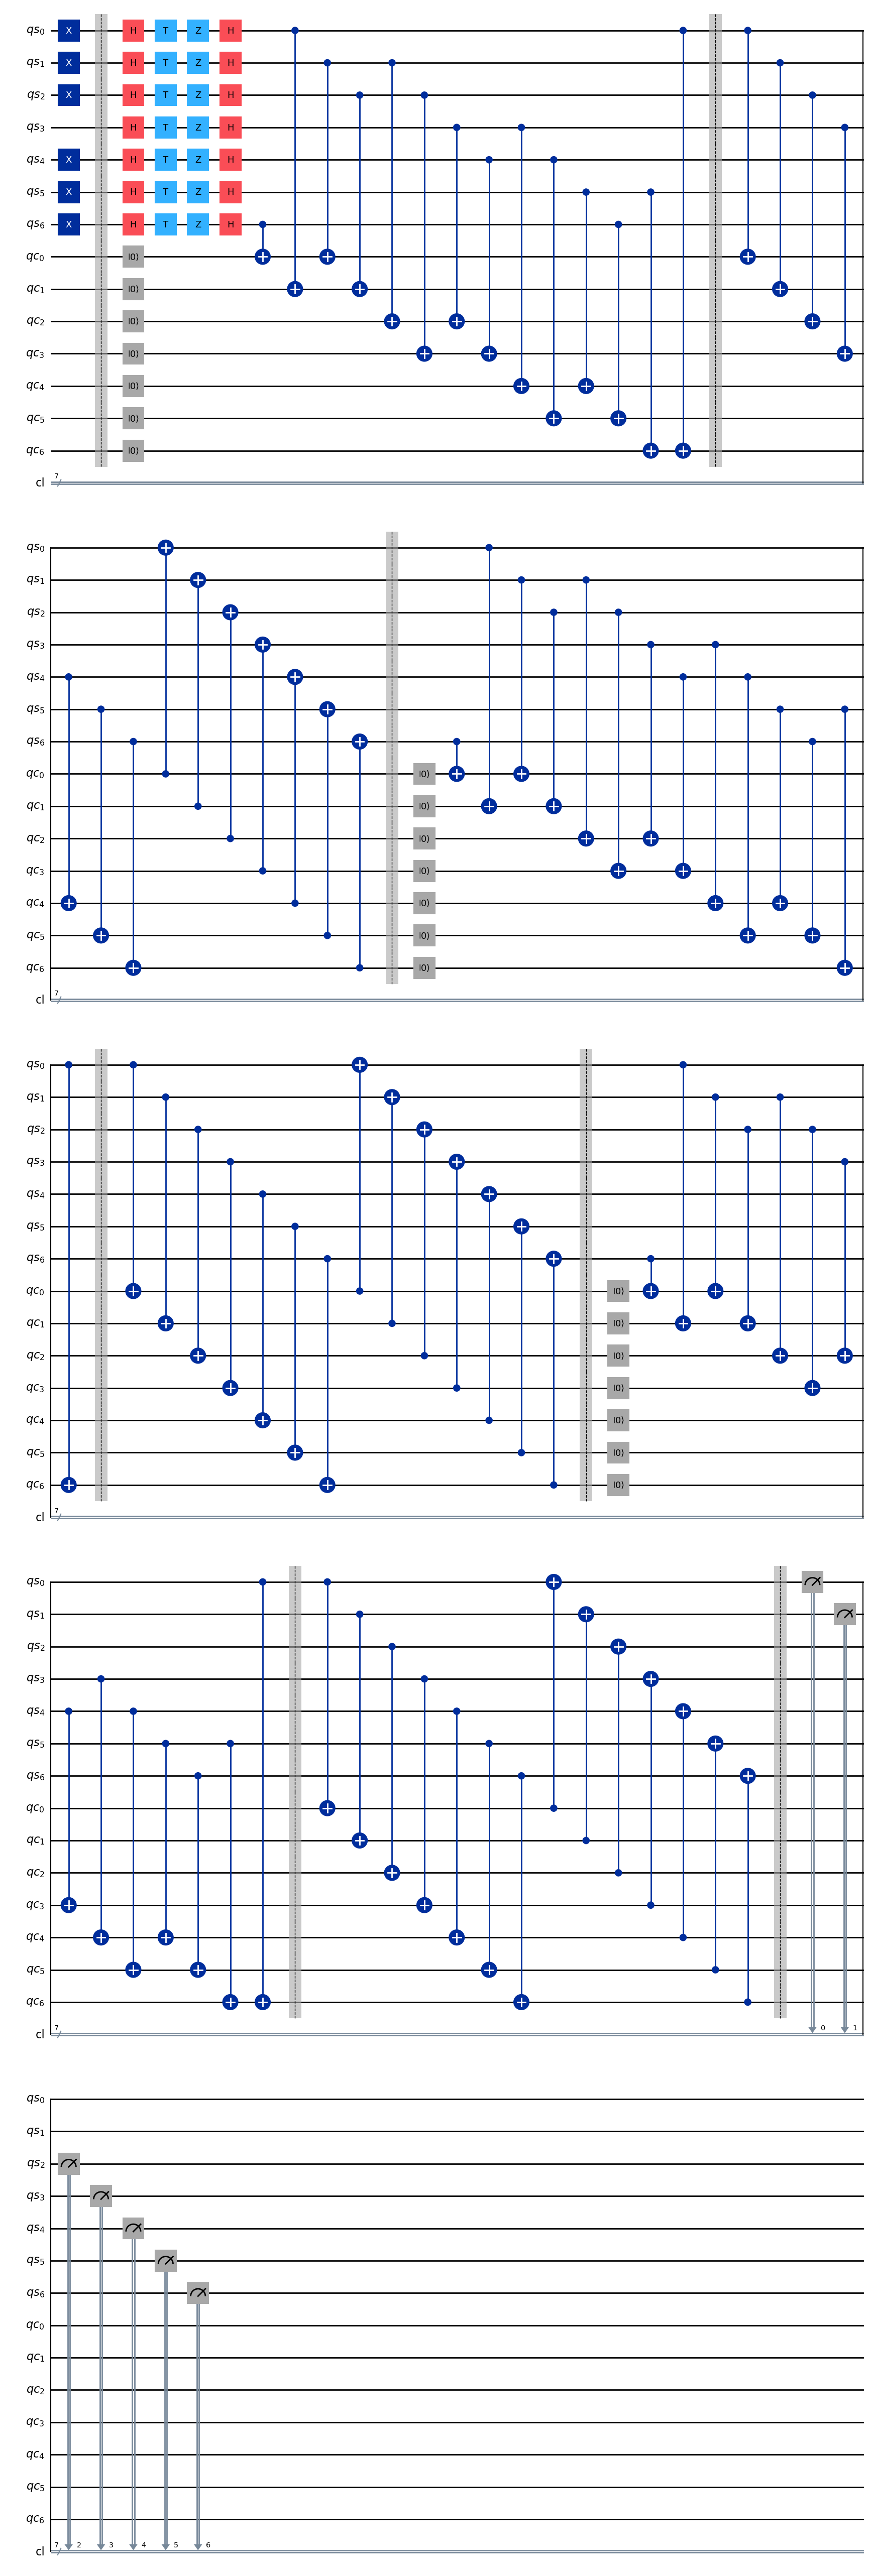

In [ ]:
ca_oracle(iterations=3).draw('mpl')

# Running Simulations

In [ ]:
#@title Simulation Functions
# @markdown Implementations of macros to simulate the circuits. The functions are:
# @markdown
# @markdown   ```python
# @markdown  simulate_noise(circuit, shots)
# @markdown  simulate_ideal(circuit, shots)
# @markdown  simulate_real(circuit, shots=1, back="")
# @markdown   ```

from qiskit_aer import AerSimulator
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit_ibm_runtime import Session
from qiskit_aer.noise import (
    NoiseModel,
    QuantumError,
    ReadoutError,
    depolarizing_error,
    pauli_error,
    thermal_relaxation_error,
)

def simulate_noise(circuit, shots=1024, backend_name=None):
    if backend_name:
      backend = service.backend(backend_name)
    else:
      backend = service.least_busy(operational=True, simulator=False, min_num_qubits=127)

    noise_model = NoiseModel.from_backend(backend)

    sim_noise = AerSimulator(noise_model=noise_model)
    pm = generate_preset_pass_manager(backend=sim_noise, optimization_level=3)
    isa_qc = pm.run(circuit)

    result = sim_noise.run(isa_qc)

    print(f">>> Job ID: {result.job_id()}")
    print(f">>> Job Status: {result.status()}")

    return result

def simulate_ideal(circuit, shots=1024):
    # Instancia o simulador
    sim_ideal = AerSimulator()

    # Otimiza o circuito para o tipo de hardware
    pm = generate_preset_pass_manager(backend=sim_ideal, optimization_level=3)
    isa_qc = pm.run(circuit)

    # Roda a simulação
    result = sim_ideal.run(circuit)

    return result

def simulate_real(circuit, shots=1, back=""):
    if back == "":
        backend = service.least_busy(operational=True, simulator=False)
    else:
        backend = service.backend(back)

    # Convert the circuit so it can be ran in the specified backend
    pm = generate_preset_pass_manager(optimization_level=1, backend=backend)
    isa_circuit = pm.run(circuit)

    # Inicia o Sampler e roda o código
    sampler = Sampler(backend=backend)
    job = sampler.run([isa_circuit], shots=shots)
    print(f">>> Job ID: {job.job_id()}")
    print(f">>> Job Status: {job.status()}")
    return job.result()

In [ ]:
def show_data(result):  # cl is the name given to the classical register name
  return pd.DataFrame.from_dict(result.get_counts(0), orient="index", columns=['counts']).sort_values(by=['counts'], ascending=False)

In [ ]:
circuits = []
ideal_results = []
noise_results = []

for i in range(N_ITERACOES):
  circuits.append(ca_oracle(iterations=i, data=data))

In [ ]:
for circuit in circuits:
  ideal_results.append(simulate_ideal(circuit))

In [ ]:
for circuit in circuits:
  noise_results.append(simulate_noise(circuit, backend_name="ibm_sherbrooke"))

>>> Job ID: f60263d5-1235-4d8a-bd06-a5cbf4d4011b
>>> Job Status: JobStatus.RUNNING
>>> Job ID: 46e945cf-56e9-4389-bf16-72c819ba5b76
>>> Job Status: JobStatus.RUNNING
>>> Job ID: 1f4ca7f2-d840-4784-8e24-065fa408060e
>>> Job Status: JobStatus.RUNNING
>>> Job ID: 7e7caddf-d81b-4ec5-a914-5003afa7125d
>>> Job Status: JobStatus.RUNNING
>>> Job ID: 8852cbd9-5cd1-411a-a9b6-9485def32124
>>> Job Status: JobStatus.RUNNING
>>> Job ID: 5f46e93f-64ba-4fd3-8ce1-c81f4bfd9541
>>> Job Status: JobStatus.RUNNING
>>> Job ID: e49fc153-ce77-4a96-9256-4a1e9fff4b69
>>> Job Status: JobStatus.RUNNING
>>> Job ID: 6f7323e6-ac15-4ca0-809f-902213340f0a
>>> Job Status: JobStatus.RUNNING
>>> Job ID: 147adc8b-a5a4-4c15-a586-02eba97db1d0
>>> Job Status: JobStatus.INITIALIZING
>>> Job ID: 17f893a1-1cd1-4ae6-b32f-b9738a5cb103
>>> Job Status: JobStatus.RUNNING
>>> Job ID: 6aa48ecd-16dd-402a-9db6-0b199a6641e2
>>> Job Status: JobStatus.RUNNING
>>> Job ID: 9f35c6d1-8d13-4509-ab42-58111c487d71
>>> Job Status: JobStatus.RUNNING

# Saving Results from Simulations

In [ ]:
#@title Functions for saving the results
# @markdown  Essa função pega todos os jobs de um determinado conjunto de experimentos e faz o download deles. `ideal` é um parâmetro booleano que controla o nome do arquivo.
# @markdown   ```python
# @markdown  save_result(jobs, ideal)
# @markdown   ```

from datetime import datetime
import json
from qiskit_ibm_runtime import RuntimeEncoder
from google.colab import files
import time

def save_result(jobs, ideal=True):  # result is a list of jobs
  current_datetime = datetime.now().strftime("%Y-%m-%d_")
  name = "ideal_" if ideal else "noise_"

  n = 0
  for job in jobs:
    name_ = name
    name_ += str(n)
    name_ += "_"
    name_ += str(current_datetime)
    with open(f"{name_}.json", "w") as f:
      json.dump(job.result(), f, cls=RuntimeEncoder)
    files.download(f"{name_}.json")
    n+=1
    time.sleep(0.5)

In [ ]:
save_result(ideal_results, ideal=True)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
save_result(noise_results, ideal=False)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Showing Results from Simulations

In [ ]:
#@title Functions for showing the results
# @markdown  Essas funções pegam os resultados de experimentos e calculam as probabilidades de um bit específico ser um para cada iteração.
# @markdown   ```python
# @markdown  calculate_bit_probabilities(counts)
# @markdown  show_result_sim(result, name='')
# @markdown   ```
# @markdown  A função `show_result_sim` recebe um array de resultados obtidos dos experimentos e o parâmetro `name` serve para alterar o título do gráfico.

import matplotlib.pyplot as plt
import numpy as np

def calculate_bit_probabilities(counts):
  num_bits = len(next(iter(counts)))  # Get the length of the bit strings
  bit_probabilities = [{'0': 0, '1': 0} for _ in range(num_bits)]
  total_counts = sum(counts.values())

  for bit_string, count in counts.items():
      for bit_pos, bit_value in enumerate(bit_string):
          bit_probabilities[bit_pos][bit_value] += count

  for bit_pos in range(num_bits):
      for bit_value in ['0', '1']:
          bit_probabilities[bit_pos][bit_value] /= total_counts

  return bit_probabilities

def show_result_sim(result, name=''):  # result is a list of jobs
  probs = []
  for i in range(len(result)):
    probs.append(calculate_bit_probabilities(result[i].result().get_counts()))

  x = np.arange(len(probs), dtype=int)
  y = np.arange(size, dtype=int)
  Z = np.zeros((len(probs), size))
  for it in range(len(probs)):
    for cell in range(size):
      Z[it][cell] = probs[it][cell]['1']

  plt.figure(figsize=(len(probs), size))
  extent = [0, len(probs), 0, size]
  plt.imshow(np.rot90(Z), extent=extent, aspect='equal', cmap='gist_yarg')
  plt.colorbar(label='Probability of being 1')
  plt.xlabel('Iteration')
  plt.ylabel('Cell')
  plt.title(f'Probability of Cell Being 1 at Each Iteration - {name}')
  plt.show()

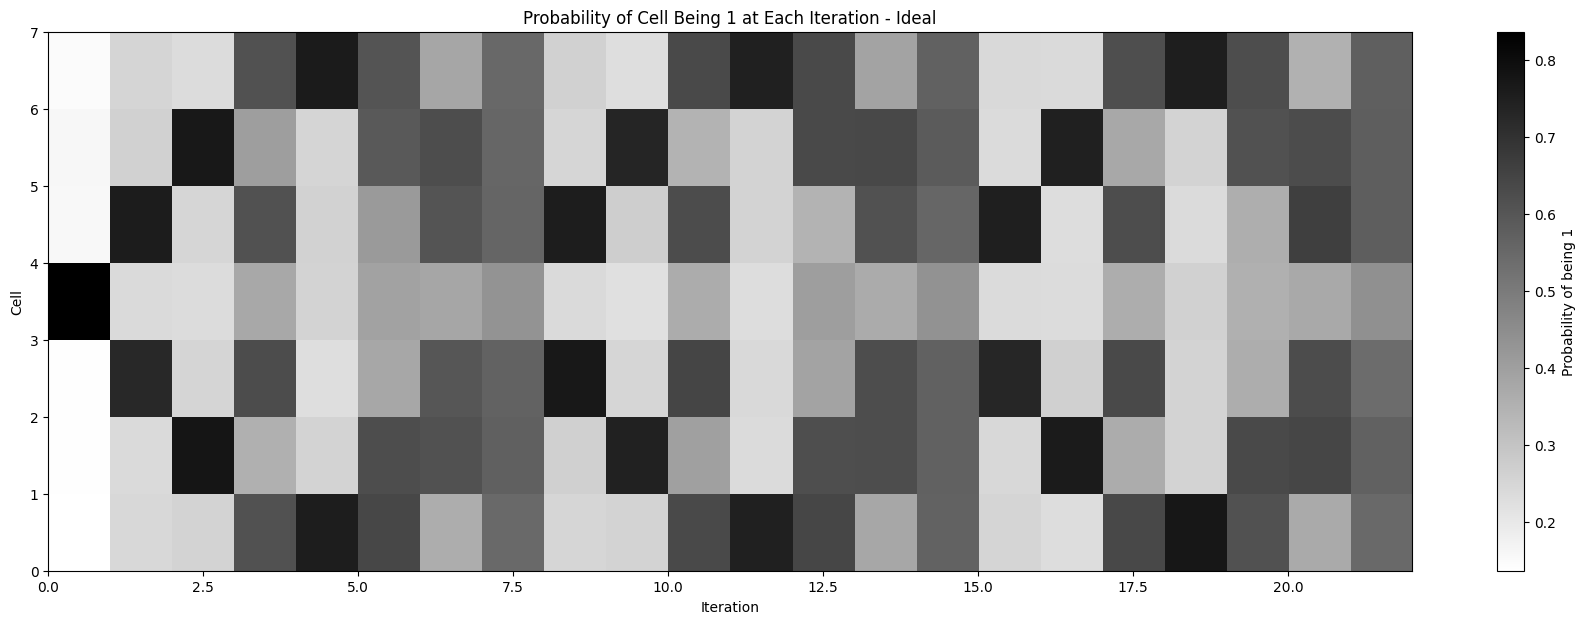

In [ ]:
show_result_sim(ideal_results, 'Ideal')

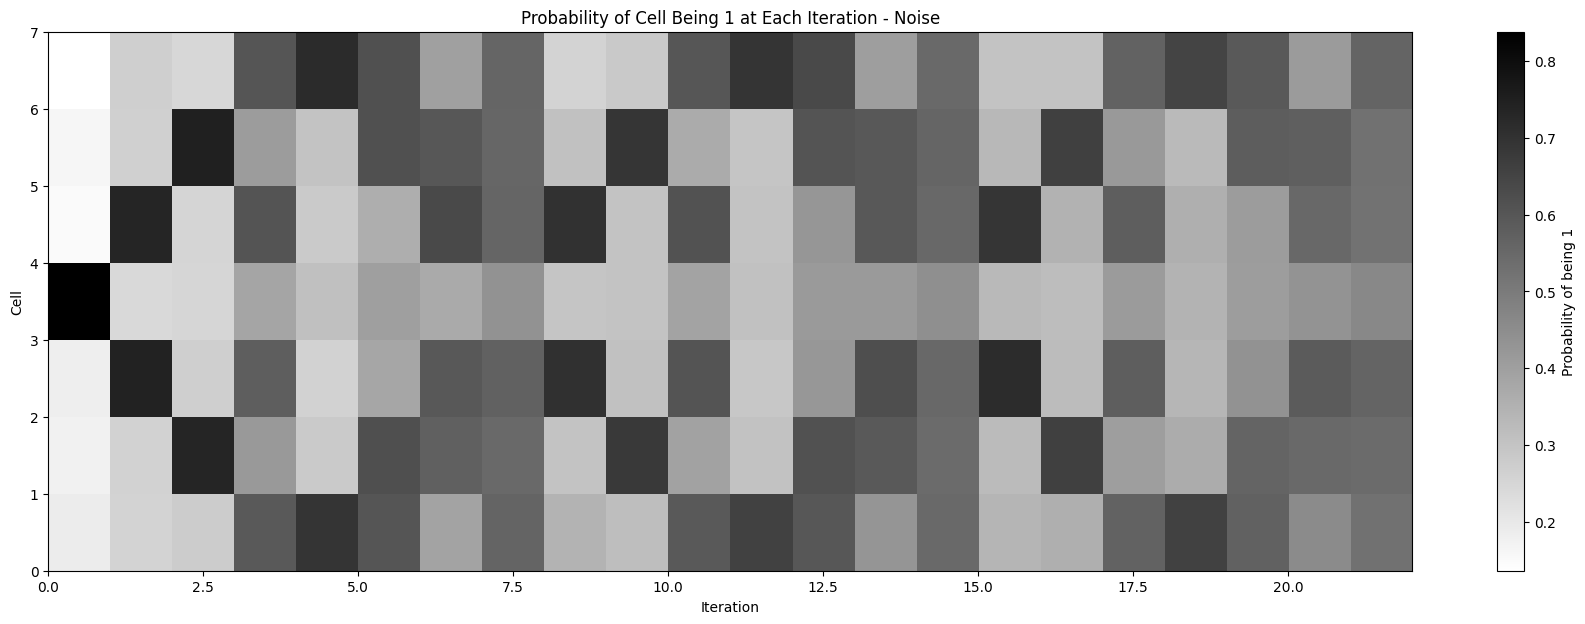

In [ ]:
show_result_sim(noise_results, 'Noise')

# Running Real stuff

In [ ]:
%%capture
backend = service.least_busy(operational=True, simulator=False, min_num_qubits=127)
jobs_list = []

with Session(backend=backend, max_time="2h") as session:
  sampler = Sampler()
  for circuit in circuits:
    # Convert the circuit so it can be ran in the specified backend
    pm = generate_preset_pass_manager(optimization_level=3, backend=backend)
    isa_circuit = pm.run(circuit)
    print([isa_circuit])

    job = sampler.run([isa_circuit], shots=5128)
    jobs_list.append(job)
    print(f">>> Job ID: {job.job_id()}")
    print(f">>> Job Status: {job.status()}")